# Baseline model:
This notebook contains our baseline model without feature engineering. We will test out  3 different classification models on our data set to see which performs best. We will then perform feature selection and hyperparameter tuning.

## Needed libraries:

In [435]:
%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [436]:
# data frame and visualization libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lantern as lt
import warnings
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

warnings.filterwarnings("ignore")

from sklearn.tree import export_graphviz

# validation and split libraries
from sklearn.model_selection import train_test_split

#

# Statistical model libraries
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV

### Functions we will use

In [437]:
from sklearn.metrics import roc_auc_score


def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    train = roc_auc_score(y_train, train_prob)
    val = roc_auc_score(y_val, val_prob)
    print("train:", round(train, 2), "Validation_test:", round(val, 2))

In [438]:
def annot(fpr, tpr, thr):
    k = 0
    for i, j in zip(fpr, tpr):
        if k % 50 == 0:
            plt.annotate(round(thr[k], 2), xy=(i, j), textcoords="data")
        k += 1

In [439]:
from sklearn.metrics import roc_curve


def roc_plot(model, X_train, y_train, X_val, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    plt.figure(figsize=(7, 7))
    for data in [[y_train, train_prob], [y_val, val_prob]]:  # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.ylabel("TPR (power)")
    plt.xlabel("FPR (alpha)")
    plt.legend(["train", "val"])
    plt.show()

In [440]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [
        col
        for col in opt.columns
        if ("mean" in col or "std" in col) and "time" not in col
    ]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)

    plt.figure(figsize=[15, 4])
    plt.subplot(121)
    sns.heatmap(
        pd.pivot_table(
            opt,
            index="max_depth",
            columns="min_samples_leaf",
            values="mean_train_score",
        )
        * 100
    )
    plt.title("ROC_AUC - Training")
    plt.subplot(122)
    sns.heatmap(
        pd.pivot_table(
            opt, index="max_depth", columns="min_samples_leaf", values="mean_test_score"
        )
        * 100
    )
    plt.title("ROC_AUC - Validation")


#     return opt

## Load the Data:

In [441]:
baseline_df = pd.read_csv("../data/telecom_cleaned.csv")

In [442]:
print("-----------------------------------------")
print("The Dataframe has:", baseline_df.shape[1], "columns")
print("The Dataframe has:", baseline_df.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
The Dataframe has: 22 columns
The Dataframe has: 3333 rows
-----------------------------------------


In [443]:
list(baseline_df.columns)

['Unnamed: 0',
 'state',
 'account_length',
 'area_code',
 'phone_number',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn',
 'international_plan_yes',
 'voice_mail_plan_yes']

## Create Train/Test/Split and Validation sets

In [444]:
# feature selection
X = baseline_df.drop(
    ["Unnamed: 0", "churn", "state", "phone_number", "area_code", "account_length"],
    axis=1,
)
y = baseline_df.loc[:, ["churn"]]

In [445]:
print("-----------------------------------------")
print("X has:", X.shape[1], "columns")
print("X has:", X.shape[0], "rows")
print("-----------------------------------------")
print("Y has:", y.shape[1], "columns")
print("Y has:", y.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
X has: 16 columns
X has: 3333 rows
-----------------------------------------
Y has: 1 columns
Y has: 3333 rows
-----------------------------------------


In [446]:
# Create our train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Create our validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [447]:
print("------------------------------------------------")
print("The X and Y Train shape is:", X_train.shape, y_train.shape)
print("The X and Y Val shape is:", X_val.shape, y_val.shape)
print("The X and Y Test shape is:", X_test.shape, y_test.shape)
print("Totals :", X_train.shape[0] + X_val.shape[0] + X_test.shape[0], "Rows")
print("------------------------------------------------")

------------------------------------------------
The X and Y Train shape is: (2132, 16) (2132, 1)
The X and Y Val shape is: (534, 16) (534, 1)
The X and Y Test shape is: (667, 16) (667, 1)
Totals : 3333 Rows
------------------------------------------------


In [448]:
baseline_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

## Baseline model Decision tree

In [449]:
from sklearn.tree import DecisionTreeClassifier

In [450]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=140)

In [451]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

In [452]:
from sklearn.metrics import roc_curve, roc_auc_score

train: 0.74 Validation_test: 0.71


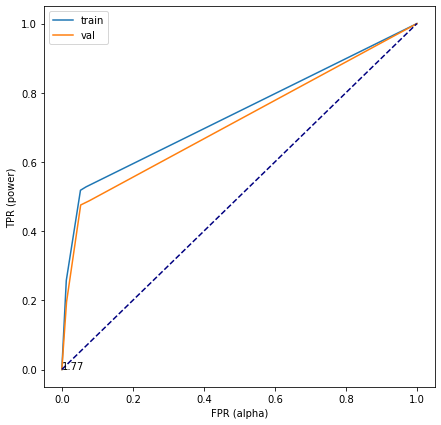

In [453]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

In [456]:
dot_data = StringIO()

export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

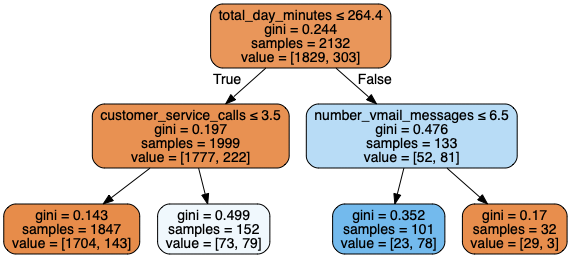

In [457]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value = [notchurn, churn]

### Metrics of evaluation:

In [458]:
y_predic = tree_clf.predict(X_val)

In [459]:
print("y predicted : \n" + str(pd.Series(y_predic).value_counts()))

y predicted : 
False    471
True      63
dtype: int64


In [460]:
# Model Evaluation metrics
print("Accuracy Score : " + str(accuracy_score(y_val, y_predic)))
print("Precision Score : " + str(precision_score(y_val, y_predic)))
print("Recall Score : " + str(recall_score(y_val, y_predic)))
print("F1 Score : " + str(f1_score(y_val, y_predic)))
# Decision tree Confusion matrix
print("Confusion Matrix : \n" + str(confusion_matrix(y_val, y_predic)))

Accuracy Score : 0.8745318352059925
Precision Score : 0.6190476190476191
Recall Score : 0.47560975609756095
F1 Score : 0.5379310344827587
Confusion Matrix : 
[[428  24]
 [ 43  39]]


# Tuned models:

## Decision Tree

In [597]:
# manual tweaks
tree_clf = DecisionTreeClassifier(
    min_samples_leaf=5, max_depth=4, random_state=140, class_weight="balanced"
)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

train: 0.9 Validation_test: 0.89


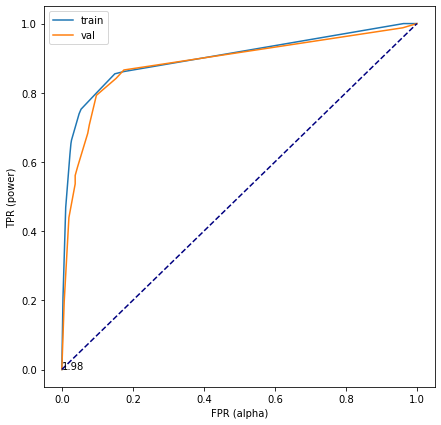

In [506]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

In [465]:
y_predic = tree_clf.predict(X_val)
print("y predicted : \n" + str(pd.Series(y_predic).value_counts()))

y predicted : 
False    396
True     138
dtype: int64


In [466]:
# Model Evaluation metrics
print("Accuracy Score : " + str(accuracy_score(y_val, y_predic)))
print("Precision Score : " + str(precision_score(y_val, y_predic)))
print("Recall Score : " + str(recall_score(y_val, y_predic)))
print("F1 Score : " + str(f1_score(y_val, y_predic)))
# Decision tree Confusion matrix
print("---------------------------------------------------")
print("Confusion Matrix : \n" + str(confusion_matrix(y_val, y_predic)))

Accuracy Score : 0.846441947565543
Precision Score : 0.5
Recall Score : 0.8414634146341463
F1 Score : 0.6272727272727273
---------------------------------------------------
Confusion Matrix : 
[[383  69]
 [ 13  69]]


## Feature importances:

In [467]:
for name, score in zip(X_train.columns, tree_clf.feature_importances_):
    print(name, ":", score)

number_vmail_messages : 0.05140150129782647
total_day_minutes : 0.20914412171315383
total_day_calls : 0.0
total_day_charge : 0.028889007092366997
total_eve_minutes : 0.11530037971928715
total_eve_calls : 0.0
total_eve_charge : 0.004689312597341045
total_night_minutes : 0.0
total_night_calls : 0.0
total_night_charge : 0.0
total_intl_minutes : 0.0
total_intl_calls : 0.03432708135291391
total_intl_charge : 0.0
customer_service_calls : 0.27400014430978237
international_plan_yes : 0.2822484519173283
voice_mail_plan_yes : 0.0


In [468]:
dot_data = StringIO()

In [469]:
export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

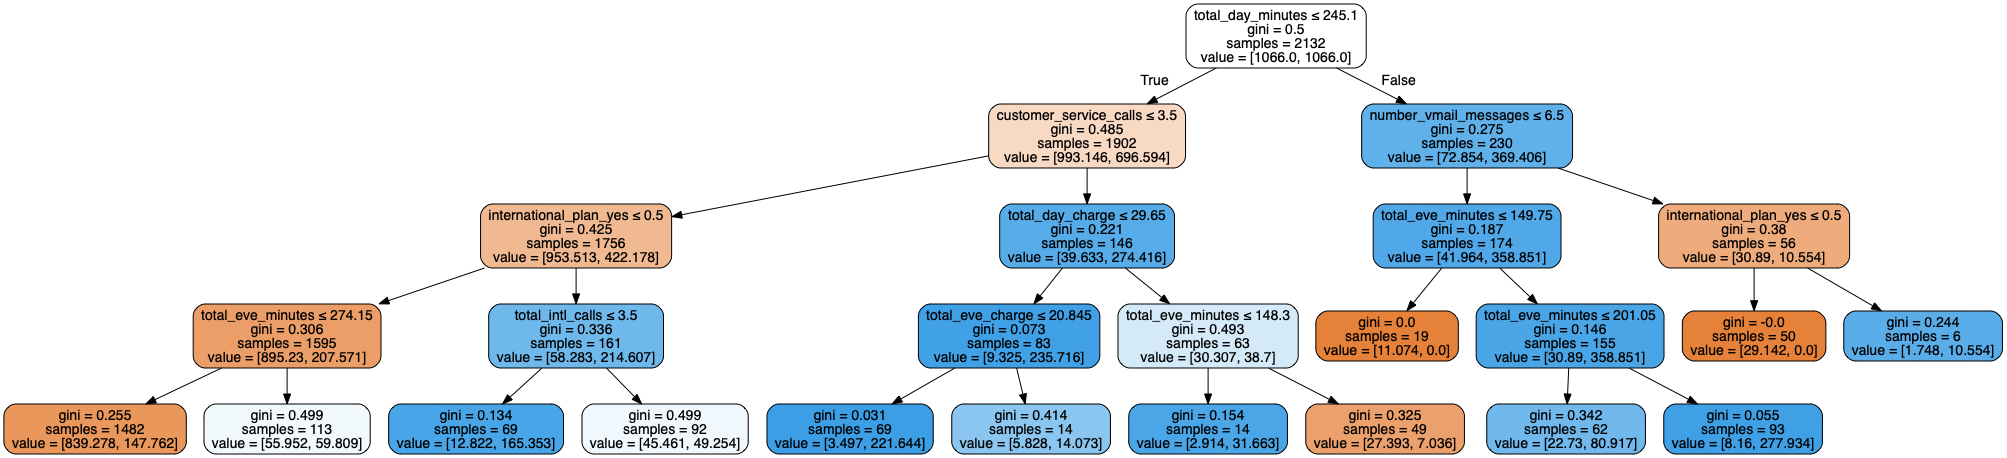

In [491]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value= [notchurn, churn]

## Grid search with the decision tree

In [593]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=5, random_state=140)

train: 0.92 Validation_test: 0.88
{'max_depth': 5, 'min_samples_leaf': 34}
CPU times: user 652 ms, sys: 20.6 ms, total: 672 ms
Wall time: 751 ms


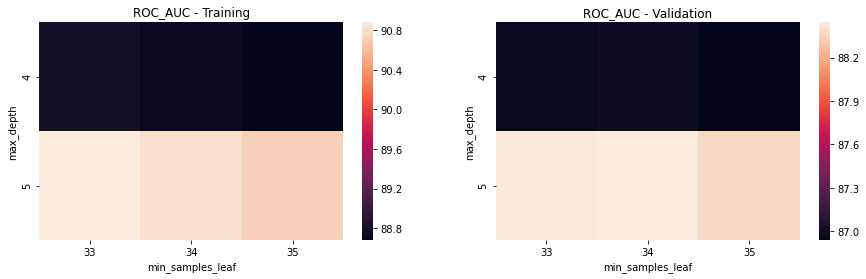

In [594]:
%%time
param_grid = {'max_depth':range(4,6), 'min_samples_leaf':range(33,36)}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.92 Validation_test: 0.88


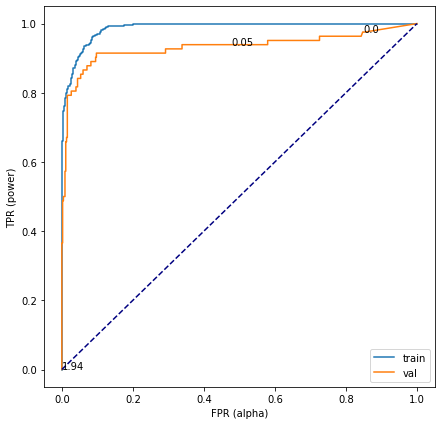

In [595]:
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(best_model, X_train, y_train, X_val, y_val)

In [ ]:
y_predic = d_tree_best_model.predict(X_val)
print("y predicted : \n" + str(pd.Series(y_predic).value_counts()))

In [ ]:
# Model Evaluation metrics
print("Accuracy Score : " + str(accuracy_score(y_val, y_predic)))
print("Precision Score : " + str(precision_score(y_val, y_predic)))
print("Recall Score : " + str(recall_score(y_val, y_predic)))
print("F1 Score : " + str(f1_score(y_val, y_predic)))
# Decision tree Confusion matrix
print("---------------------------------------------------")
print("Confusion Matrix : \n" + str(confusion_matrix(y_val, y_predic)))

## K nearest neighbours

In [598]:
from sklearn.neighbors import KNeighborsClassifier

In [603]:
knn_clf = KNeighborsClassifier(n_neighbors=19, metric="manhattan")
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

train: 0.81 Validation_test: 0.78


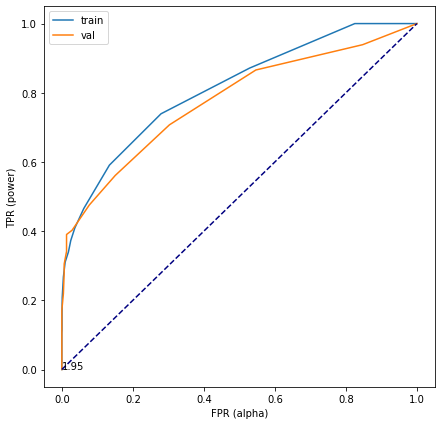

In [604]:
scores(knn_clf, X_train, X_val, y_train, y_val)
roc_plot(knn_clf, X_train, y_train, X_val, y_val)

## K nearest neighbors grid search

In [588]:
%%time
grid_params = {
    "n_neighbors": [3, 5, 11, 19],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

opt_model = GridSearchCV(knn_clf, grid_params, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
knn_best_model = opt_model.best_estimator_

scores(knn_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)

train: 1.0 Validation_test: 0.79
{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
CPU times: user 4.7 s, sys: 46.6 ms, total: 4.74 s
Wall time: 5.52 s


## Random Forrest

In [577]:
from sklearn.ensemble import RandomForestClassifier
rndf_clf = RandomForestClassifier(n_estimators=100, random_state=140)
rndf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=140,
                       verbose=0, warm_start=False)

### Grid search random Forrest

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.990, test=0.866), total=   0.4s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.887), total=   0.3s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.989, test=0.903), total=   0.3s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.986, test=0.948), total=   0.3s
[CV] max_depth=10, min_samples_leaf=5 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=5, score=(train=0.987, test=0.949), total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.988, test=0.865), total=   0.3s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.985, test=0.883), total=   0.3s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.986, test=0.907), total=   0.3s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.983, test=0.950), total=   0.3s
[CV] max_depth=10, min_samples_leaf=6 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=6, score=(train=0.984, test=0.939), total=   0.3s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.987, test=0.869), total=   0.3s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.983, test=0.884), total=   0.3s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.984, test=0.899), total=   0.3s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.981, test=0.945), total=   0.3s
[CV] max_depth=10, min_samples_leaf=7 ................................
[CV]  max_depth=10, min_samples_leaf=7, score=(train=0.982, test=0.947), total=   0.3s
[CV] max_depth=10, min_samples_leaf=8 ................................
[CV]  max_depth=10, min_samples_leaf=8, score=(train

[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:  1.6min finished


train: 0.99 Validation_test: 0.94
{'max_depth': 12, 'min_samples_leaf': 5}
CPU times: user 1min 24s, sys: 1.13 s, total: 1min 25s
Wall time: 1min 37s


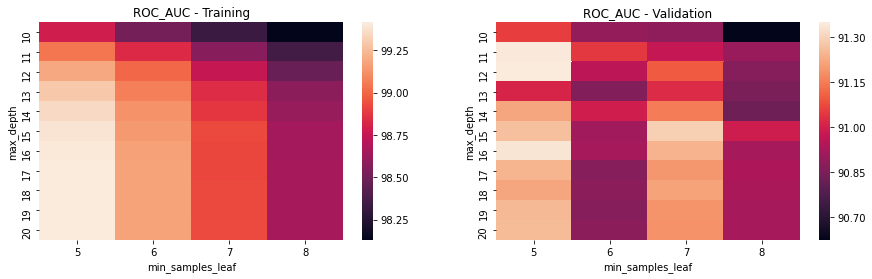

In [607]:
%%time
param_grid = {'max_depth':range(10,21),'min_samples_leaf':[5,6,7,8]}

opt_model = GridSearchCV(rndf_clf,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,verbose=10)
opt_model.fit(X_train,y_train)
rndf_best_model = opt_model.best_estimator_

scores(rndf_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 Validation_test: 0.94


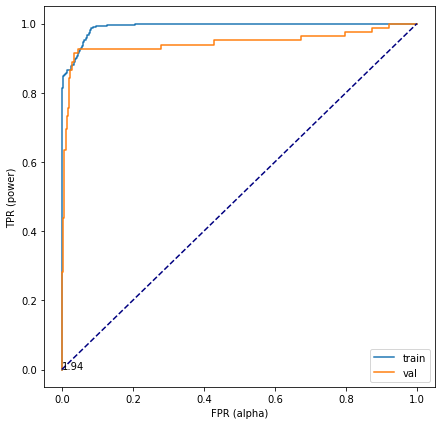

In [608]:
scores(rndf_best_model, X_train, X_val, y_train, y_val)
roc_plot(rndf_best_model, X_train, y_train, X_val, y_val)

### Random Forrest feature importances:

In [609]:
for name, score in zip(X_train.columns, rndf_best_model.feature_importances_):
    print(name, score)

number_vmail_messages 0.021226097261095395
total_day_minutes 0.16653920283021378
total_day_calls 0.01844674419939353
total_day_charge 0.15631335827169984
total_eve_minutes 0.06853350636536568
total_eve_calls 0.018806867042229548
total_eve_charge 0.06606679178615037
total_night_minutes 0.0256698265434915
total_night_calls 0.022437482463440957
total_night_charge 0.021972582860002123
total_intl_minutes 0.04200674272804962
total_intl_calls 0.04998653395511894
total_intl_charge 0.03653431635504621
customer_service_calls 0.1567262199772456
international_plan_yes 0.09962364783679384
voice_mail_plan_yes 0.029110079524663057


## Logistic Regression (soledad's)

In [487]:
log_clf = LogisticRegression(penalty="none", solver="lbfgs", class_weight="balanced")
log_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [488]:
y_hat_train = log_clf.predict_proba(X_train)[:, 1]
y_hat_val = log_clf.predict_proba(X_val)[:, 1]

## Comparison of models:

In [610]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rndf_best_model, knn_best_model, d_tree_best_model):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print("                     Accuracy|Precision|Recall|F1 Score")
    print("                     ------------------------------------")
    print(
        clf.__class__.__name__,
        ":",
        round(accuracy_score(y_val, y_pred), 3),
        "|",
        round(precision_score(y_val, y_pred), 3),
        "|",
        round(recall_score(y_val, y_pred), 3),
        "|",
        round(f1_score(y_val, y_pred), 3),
    )

                     Accuracy|Precision|Recall|F1 Score
                     ------------------------------------
LogisticRegression : 0.702 | 0.303 | 0.72 | 0.426
                     Accuracy|Precision|Recall|F1 Score
                     ------------------------------------
RandomForestClassifier : 0.936 | 0.914 | 0.646 | 0.757
                     Accuracy|Precision|Recall|F1 Score
                     ------------------------------------
KNeighborsClassifier : 0.884 | 0.885 | 0.28 | 0.426
                     Accuracy|Precision|Recall|F1 Score
                     ------------------------------------
DecisionTreeClassifier : 0.888 | 0.6 | 0.805 | 0.688


Decision tree is our chosen model

# Chosen model (Decision Tree)